In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [15]:
data = yf.download('ETH-USD',start='2018-01-01', end='2025-01-01', interval='1d')
data.sort_index(inplace=True)
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824
...,...,...,...,...,...
2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403
2024-12-28,3397.902344,3419.920166,3318.033936,3328.774658,14305648523


In [16]:
data.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=2557, freq=None)

As we can see, the dataset is already formatted to have the date as the index along with its datatype being in the correct datetime format.
No form of index resetting is required.

In [17]:
data.columns

MultiIndex([( 'Close', 'ETH-USD'),
            (  'High', 'ETH-USD'),
            (   'Low', 'ETH-USD'),
            (  'Open', 'ETH-USD'),
            ('Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])

In [ ]:
# Flatten Multi-index to get only the first level
data.columns = data.columns.get_level_values(0)

# Remove Multi-index column list name
data.columns.name = None
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [19]:
# View column datatypes
print('Column datatypes')
print(data.dtypes)

# Check for Empty Cells
print('\nEmpty Cells Present?')
print(data.isna().sum())

#Check for null values (0s)
print('\nNull Values Present?')
print(data.isnull().sum())

Column datatypes
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Empty Cells Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Null Values Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [20]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824
...,...,...,...,...,...
2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403
2024-12-28,3397.902344,3419.920166,3318.033936,3328.774658,14305648523
2024-12-29,3349.513428,3406.648438,3321.664795,3397.862549,13440907792


## Exploratory Data Analysis (EDA)

In [21]:
data.describe()

,Close,High,Low,Open,Volume
count,2557.000000,2557.000000,2557.000000,2557.000000,2.557000e+03
mean,1511.365150,1551.575457,1465.607665,1510.525290,1.324921e+10
std,1231.080013,1263.858373,1194.403502,1230.923701,1.057707e+10
min,84.308296,85.342743,82.829887,84.279694,9.484880e+08
25%,262.331726,269.641235,249.111847,262.388641,5.863109e+09
50%,1469.741699,1541.334717,1423.264771,1461.133179,1.080788e+10
75%,2431.946533,2498.507080,2340.920410,2429.980957,1.788020e+10
max,4812.087402,4891.704590,4718.039062,4810.071289,8.448291e+10


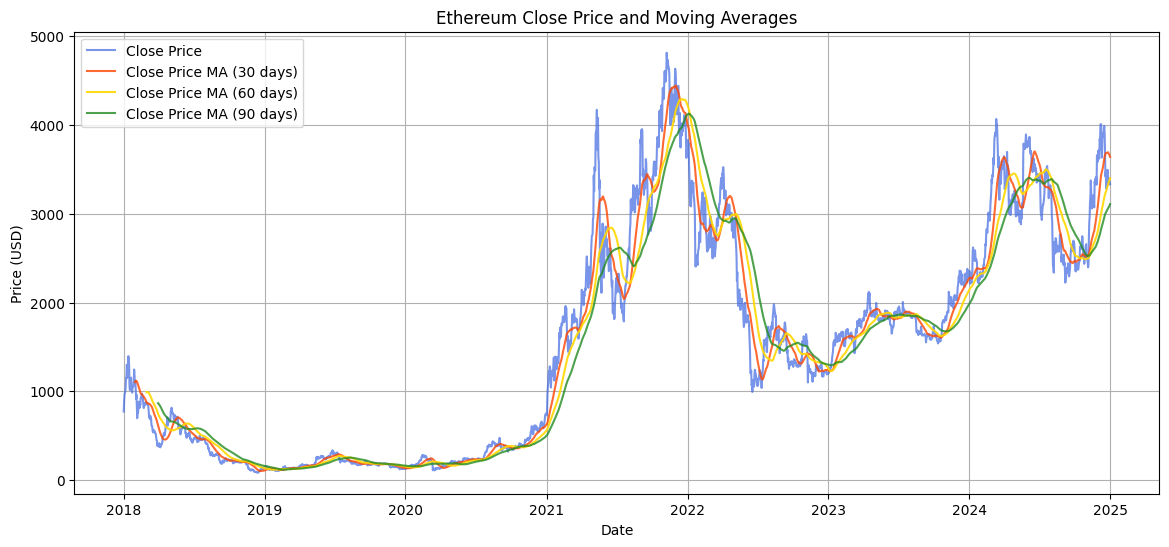

In [22]:
plt.figure(figsize=(14, 6))

# Lineplots of Closing Price and Moving Averages of 30, 60, & 90 days
sns.lineplot(data=data, x=data.index, y=data['Close'], alpha=0.7, color='royalblue', label='Close Price')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=30).mean(), alpha=0.8, color='orangered', label='Close Price MA (30 days)')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=60).mean(), alpha=0.9, color='gold', label='Close Price MA (60 days)')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=90).mean(), alpha=0.8, color='forestgreen', label='Close Price MA (90 days)')

plt.title('Ethereum Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Strong evidence that the data is not stationary. This confirms our non-stationary assumption from visual inspection.

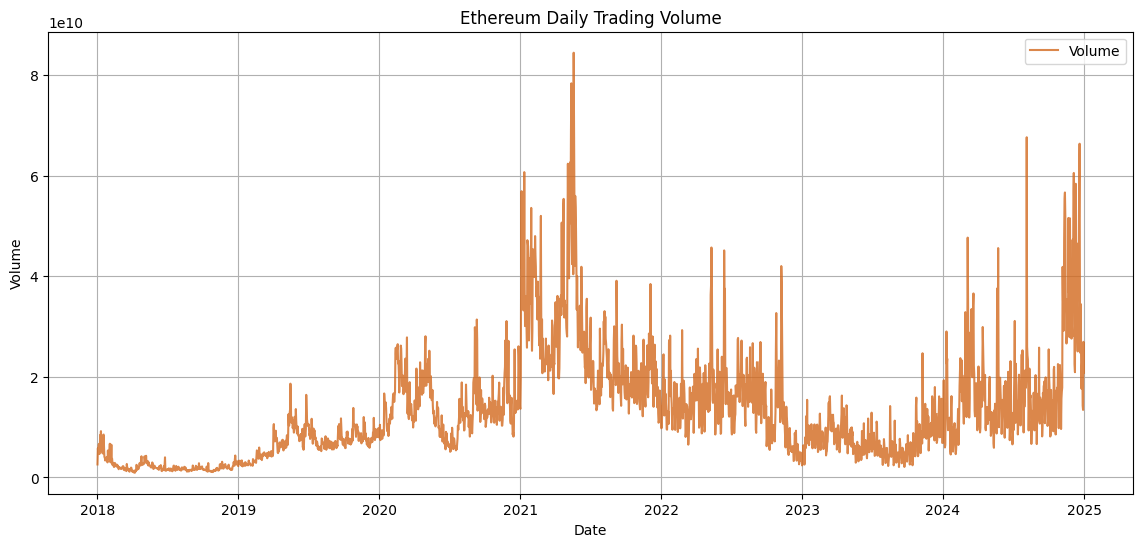

In [23]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data.index, y=data['Volume'], alpha=0.8, color='chocolate', label='Volume')

plt.title('Ethereum Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

<Figure size 1400x600 with 0 Axes>

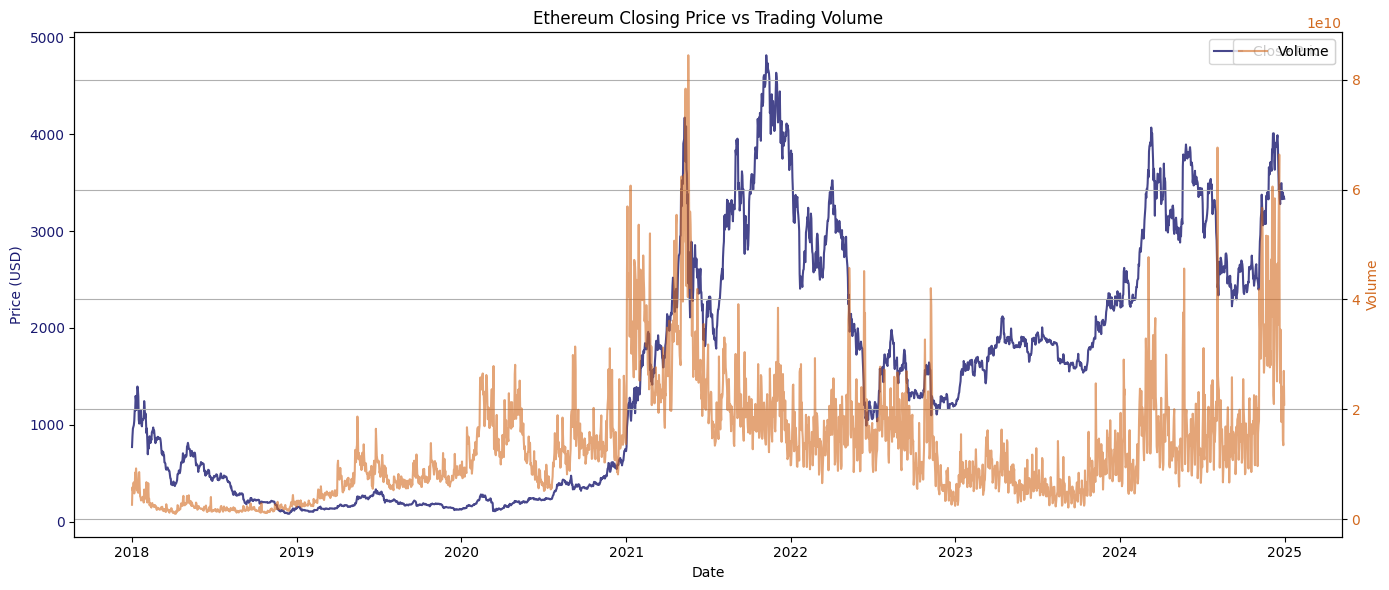

In [24]:
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Closing Price Plot
sns.lineplot(ax=ax1, data=data, x=data.index, y='Close', color='midnightblue', alpha=0.8, label='Close Price')
ax1.set_ylabel('Price (USD)', color='midnightblue')
ax1.tick_params(axis='y', labelcolor='midnightblue')

# Trading Volume Plot
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, data=data, x=data.index, y='Volume', color='chocolate', alpha=0.6, label='Volume')
ax2.set_ylabel('Volume', color='chocolate')
ax2.tick_params(axis='y', labelcolor='chocolate')

plt.title('Ethereum Closing Price vs Trading Volume')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.grid(True)
plt.show()

In [25]:
# Function to perform Augmented Dickey Fuller test
def adf_test (data, title):
    result = adfuller(data)
    print(f'{title} ADF Test')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

# Check for stationarity using Augmented Dickey Fuller test
adf_test(data['Close'], title='Close Price')

Close Price ADF Test
ADF Statistic: -1.2266310439660848
p-value: 0.6620360962440417


In [26]:
# Get returns & first differenced data
eth_returns = data['Close'].pct_change().dropna()
eth_diff = data['Close'].diff().dropna()

print(f'Percentage change/Returns:\n{eth_returns}')
print(f'\nFirst difference:\n{eth_diff}')

Percentage change/Returns:
Date
2018-01-02    0.144702
2018-01-03    0.088503
2018-01-04    0.018907
2018-01-05    0.017125
2018-01-06    0.044061
                ...   
2024-12-27   -0.000693
2024-12-28    0.020723
2024-12-29   -0.014241
2024-12-30    0.002054
2024-12-31   -0.007109
Name: Close, Length: 2556, dtype: float64

First difference:
Date
2018-01-02    111.802979
2018-01-03     78.276001
2018-01-04     18.202026
2018-01-05     16.797974
2018-01-06     43.960083
                 ...    
2024-12-27     -2.308838
2024-12-28     68.985352
2024-12-29    -48.388916
2024-12-30      6.879150
2024-12-31    -23.860840
Name: Close, Length: 2556, dtype: float64


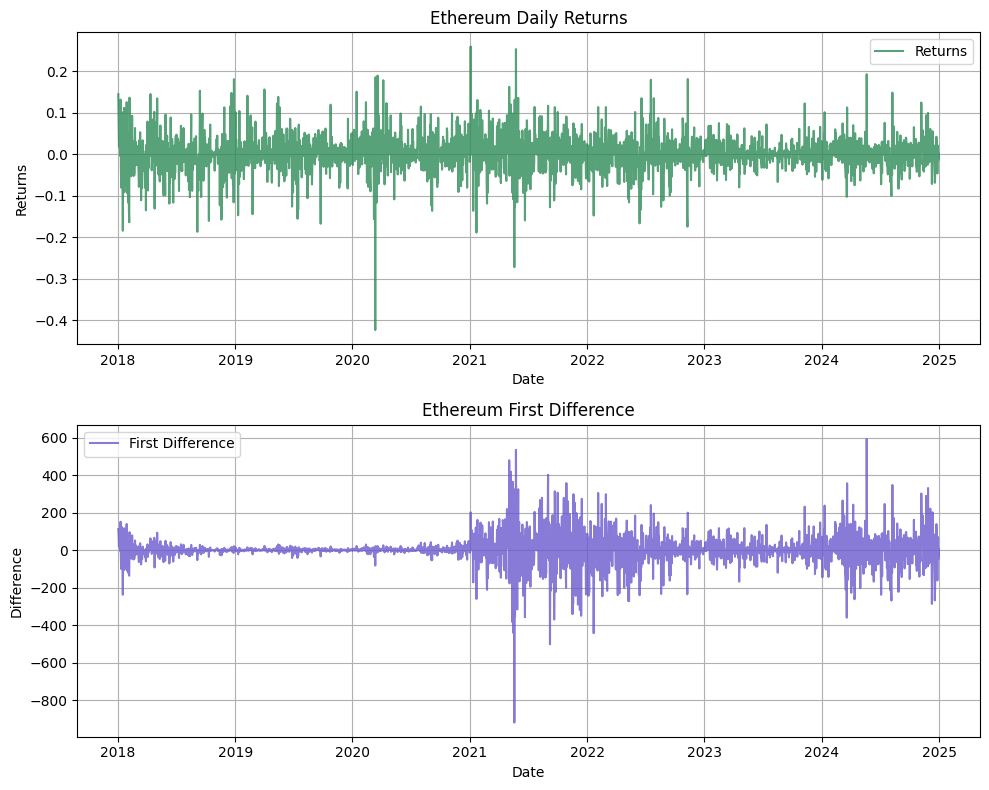

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot Returns
sns.lineplot(ax=axes[0], x=eth_returns.index, y=eth_returns.values, color='seagreen', label='Returns', alpha=0.8)
axes[0].set_title('Ethereum Daily Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].grid(True)

# Plot First Differences
sns.lineplot(ax=axes[1], x=eth_diff.index, y=eth_diff.values, color='slateblue', label='First Difference', alpha=0.8)
axes[1].set_title('Ethereum First Difference')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Difference')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
adf_test(data=eth_returns, title='Returns')
print()
adf_test(data=eth_diff, title='First Difference')

Returns ADF Test
ADF Statistic: -15.266983458813222
p-value: 4.774396895151701e-28

First Difference ADF Test
ADF Statistic: -12.53846364258021
p-value: 2.3431118738983896e-23


The **Returns** and **Closing Price First Difference** graph shows strong stationarity as indicated by the ADF Test

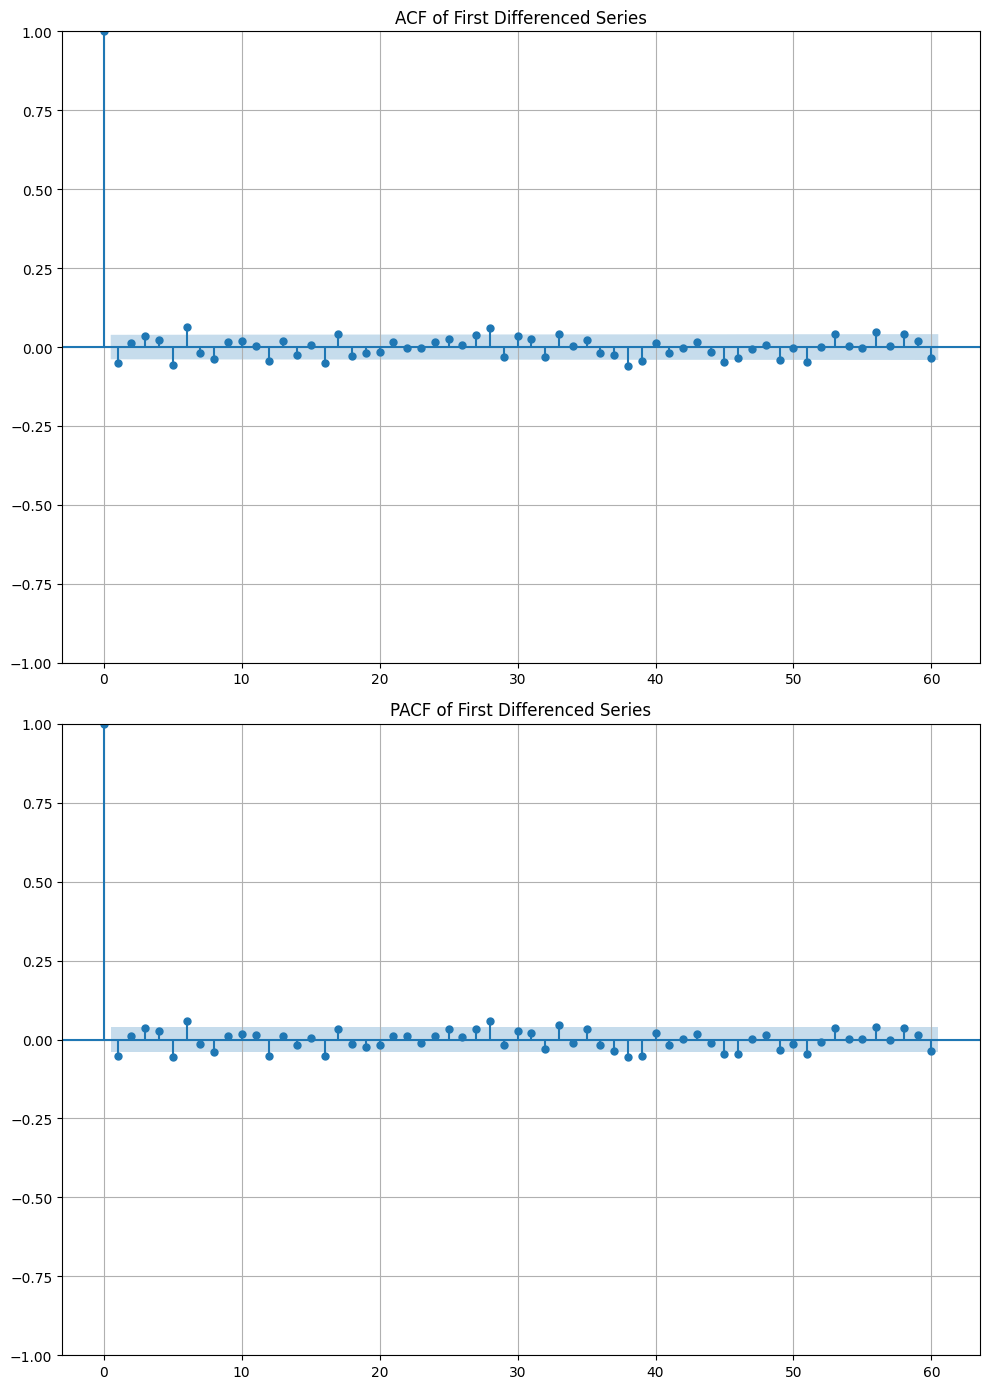

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 14))

# Plot ACF
plot_acf(eth_diff, lags=60, ax=axes[0])
axes[0].set_title('ACF of First Differenced Series')
axes[0].grid(True)

# Plot PACF
plot_pacf(eth_diff, lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF of First Differenced Series')
axes[1].grid(True)

plt.tight_layout()
plt.show()

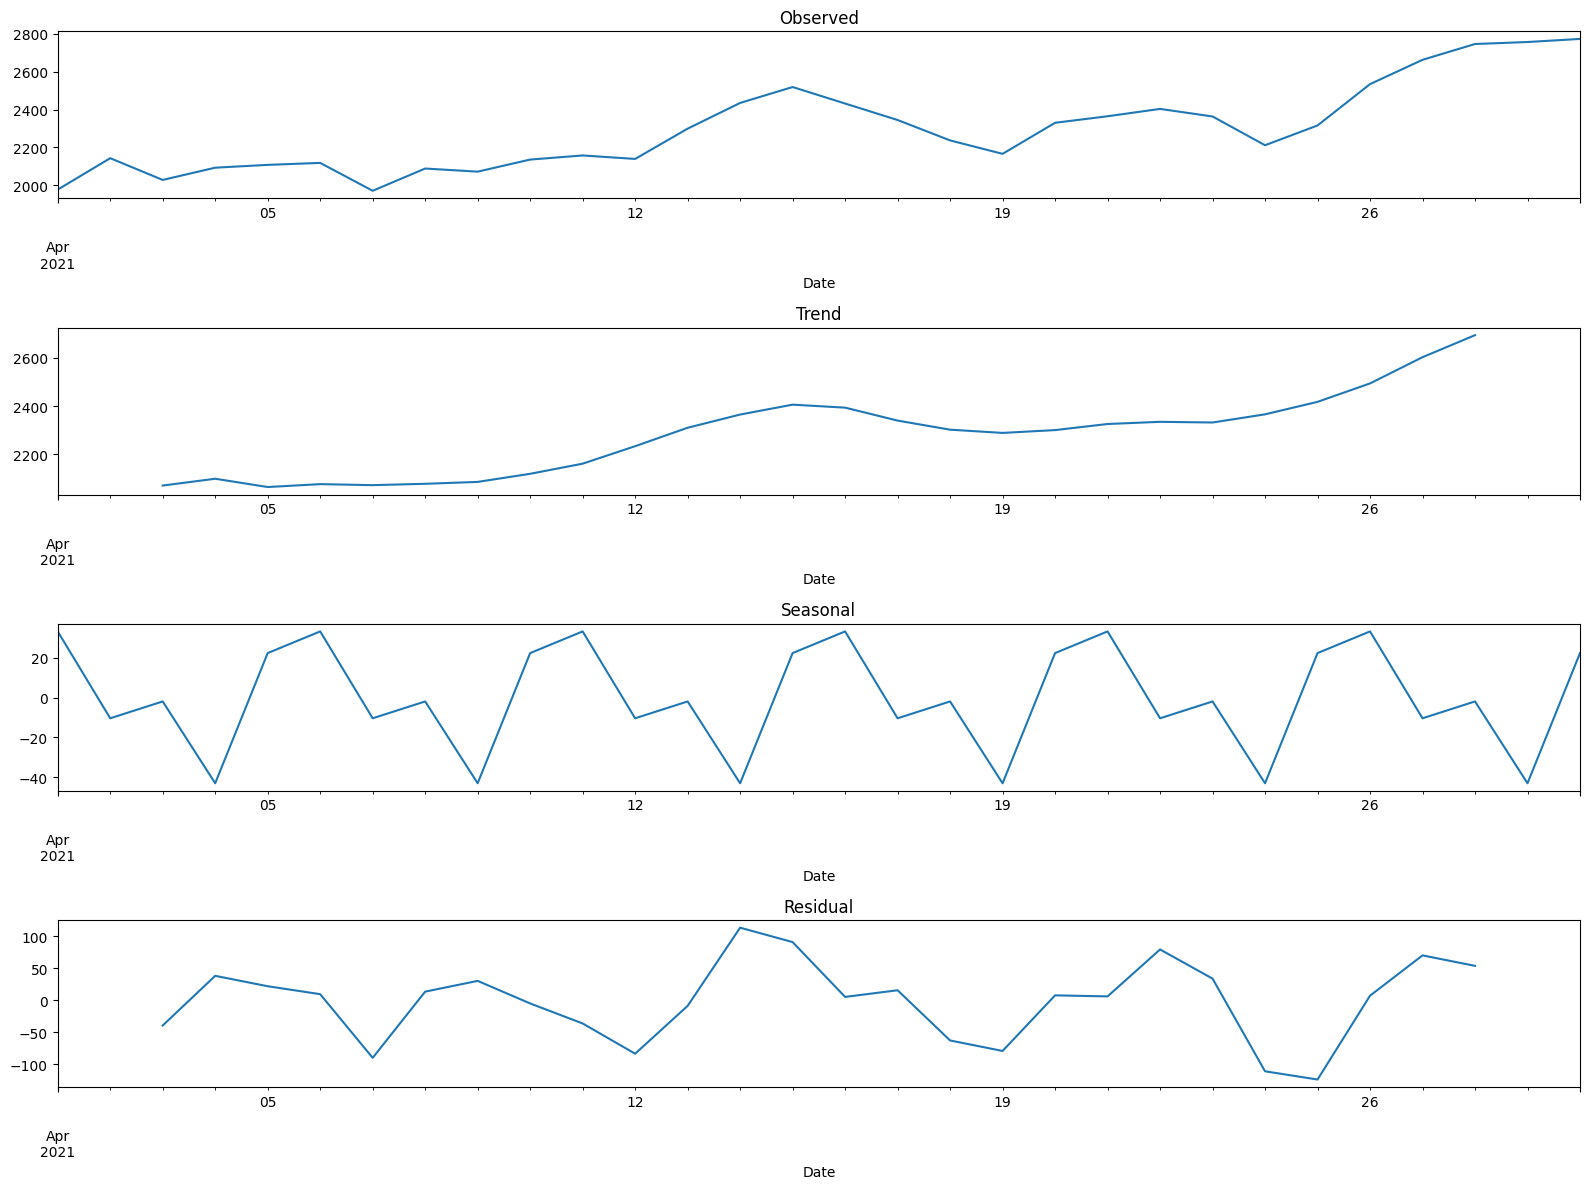

In [30]:
# Perform decomposition
year = 2021
month = 4
decomposition = seasonal_decompose(data[(data.index.year == year) & (data.index.month == month)]['Close'], model='additive', period=5)

# Set larger figure size
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Plot each component
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

Looks like there is some seasonal component influencing the overall trend.

In [31]:
train_data = data[data.index < '2024-12-01']['Close']
test_data = data[data.index >= '2024-12-01']['Close']

Lets try a basic ARIMA (1,1,1) model

In [32]:
arima = ARIMA(train_data, order=(1,1,1))
model_fit = arima.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2526
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14618.583
Date:                Mon, 05 May 2025   AIC                          29243.165
Time:                        17:40:47   BIC                          29260.667
Sample:                    01-01-2018   HQIC                         29249.516
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1690      0.168     -1.004      0.315      -0.499       0.161
ma.L1          0.1119      0.171      0.656      0.512      -0.222       0.446
sigma2      6257.3578     64.117     97.592      0.000    6131.690    6383.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22460.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               8.97   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
best_arima_predictions = model_fit.forecast(len(test_data))
roll_daily_residuals = test_data - best_arima_predictions

Plot the residuals trend

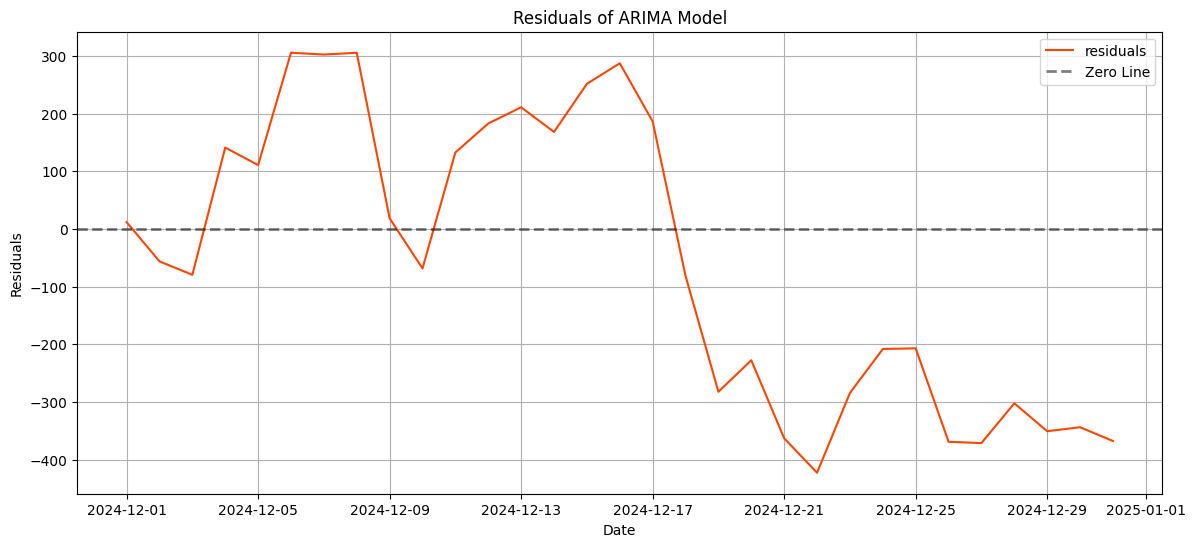

In [ ]:
plt.figure(figsize=(14, 6))

sns.lineplot(x=test_data.index, y=roll_daily_residuals, color='orangered', label='residuals')
plt.axhline(y=0, color='black', label='Zero Line', linewidth ='2', linestyle='--', alpha=0.5)

plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

Plot the predicted values against the actual values (Predictions vs Test dataset)

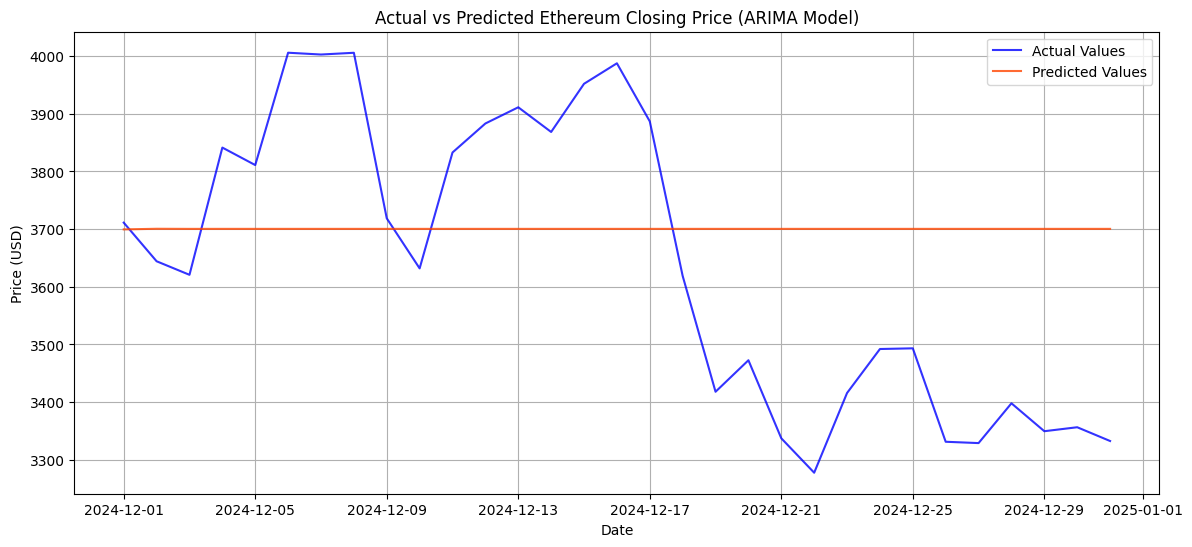

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data, color='blue', label='Actual Values', alpha=0.8)
plt.plot(test_data.index, best_arima_predictions, color='orangered', label='Predicted Values', alpha=0.8)
plt.title('Actual vs Predicted Ethereum Closing Price (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
mae = mean_absolute_error(test_data, best_arima_predictions)
mse = mean_squared_error(test_data, best_arima_predictions)
rmse = root_mean_squared_error(test_data, best_arima_predictions)
mape = mean_absolute_percentage_error(test_data, best_arima_predictions)
r2 = r2_score(test_data,best_arima_predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R^2 Score (R2): {r2}')

Mean Absolute Error (MAE): 225.86925197548655
Mean Squared Error (MSE): 64114.9125524756
Root Mean Squared Error (RMSE): 253.20922683124246
Mean Absolute Percentage Error (MAPE): 0.06324556844327778%
R^2 Score (R2): -0.053919855955518514


Fair to say, it performed really poorly, not capturing any trends at all. Lets try using a weekly approach by incorporating 7 day lags into the AR & MA components of the ARIMA model.

In [37]:
p_vals = range(0,8)
q_vals = range(0,8)
d = 1

all_arima = []

for p in p_vals:
    for q in q_vals:
        try:
            model = ARIMA(train_data, order=(p,d,q))
            model_fit1 = model.fit()
            predictions = model_fit1.forecast(len(test_data))
            
            mae = mean_absolute_error(test_data, predictions)
            mse = mean_squared_error(test_data, predictions)
            rmse = root_mean_squared_error(test_data, predictions)
            mape = mean_absolute_percentage_error(test_data, predictions)
            
            all_arima.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape})
            
        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")
            
arima_df = pd.DataFrame(all_arima)

In [38]:
arima_df.sort_values(by='RMSE', inplace=True)
arima_df.reset_index(drop=True, inplace=True)
arima_df

,Order,MAE,MSE,RMSE,MAPE
0,"(4, 1, 7)",202.111613,50823.262760,225.440153,0.055809
1,"(7, 1, 1)",221.803454,61435.110470,247.861071,0.061907
2,"(5, 1, 7)",222.174441,61568.766619,248.130544,0.062109
3,"(5, 1, 5)",222.273065,61798.916053,248.593878,0.062302
4,"(7, 1, 4)",223.152876,62232.899448,249.465227,0.062461
...,...,...,...,...,...
59,"(6, 1, 7)",231.458912,68681.226347,262.071033,0.065337
60,"(7, 1, 6)",230.888467,70509.187252,265.535661,0.065487
61,"(5, 1, 4)",234.558986,71979.215827,268.289425,0.066297
62,"(5, 1, 6)",234.952608,71984.905449,268.300029,0.066428


In [77]:
arima_df.to_csv('arima_results.csv', index=False)

In [39]:
best_order = arima_df.iloc[0]['Order']
print(f"Best ARIMA order based on RMSE: {best_order}")

Best ARIMA order based on RMSE: (4, 1, 7)


In [ ]:
best_arima = ARIMA(train_data, order=(4,1,7))

best_model_fit = best_arima.fit()
best_arima_predictions = best_model_fit.forecast(len(test_data))

roll_daily_residuals = test_data - best_arima_predictions

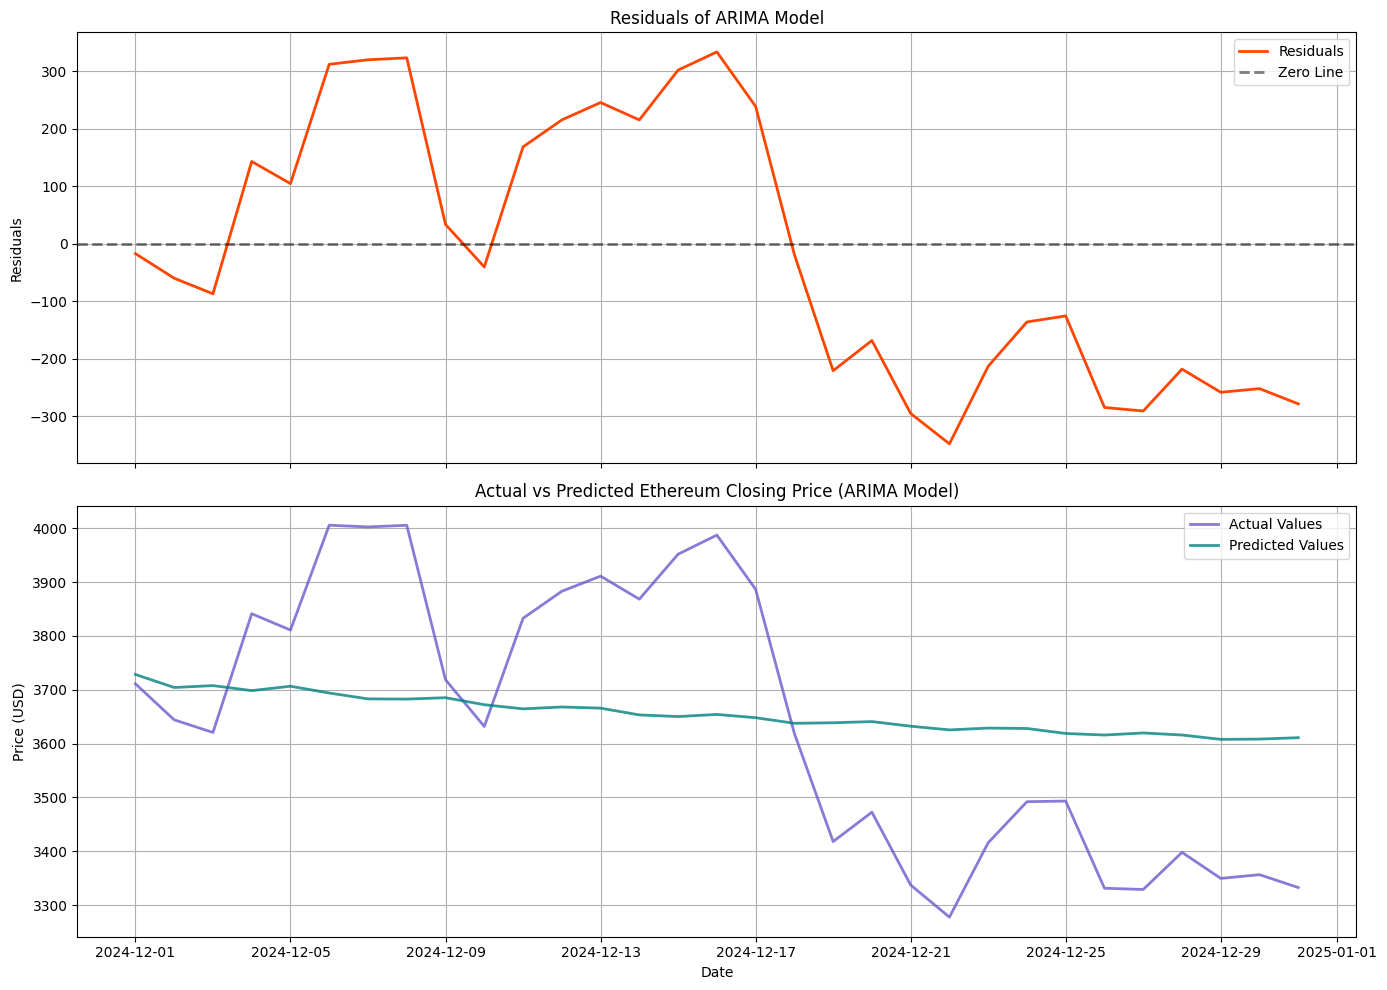

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plot 1: Residuals
sns.lineplot(ax=axes[0], x=test_data.index, y=roll_daily_residuals, color='orangered', label='Residuals', linewidth=2)
axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
axes[0].set_title('Residuals of ARIMA Model')
axes[0].set_ylabel('Residuals')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Actual vs Predicted
axes[1].plot(test_data.index, test_data, color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
axes[1].plot(test_data.index, best_arima_predictions, color='teal', label='Predicted Values', alpha=0.8, linewidth=2)
axes[1].set_title('Actual vs Predicted Ethereum Closing Price (ARIMA Model)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
'''
p_vals = range(0,8)
q_vals = range(0,8)
d = 1

all_arima_rolls = []

for p in p_vals:
    for q in q_vals:
        
        arima_roll_preds = pd.Series()
        
        for end_date in test_data.index:
            train_data_roll = data['Close'][:(end_date - timedelta(days=1))]
            model = ARIMA(train_data_roll, order=(p,d,q))
            model_fit = model.fit()
            preds = model_fit.forecast(end_date)
            arima_roll_preds.loc[end_date]
'''                        

"\np_vals = range(0,8)\nq_vals = range(0,8)\nd = 1\n\nall_arima_rolls = []\n\nfor p in p_vals:\n    for q in q_vals:\n        \n        arima_roll_preds = pd.Series()\n        \n        for end_date in test_data.index:\n            train_data_roll = data['Close'][:(end_date - timedelta(days=1))]\n            model = ARIMA(train_data_roll, order=(p,d,q))\n            model_fit = model.fit()\n            preds = model_fit.forecast(end_date)\n            arima_roll_preds.loc[end_date]\n"

In [ ]:
'''
p_vals = range(0, 8)
q_vals = range(0, 8)
d = 1

r_arima_daily = []

for p in p_vals:
    for q in q_vals:
        r_arima_preds = pd.Series(dtype=float)

        try:
            for end_date in test_data.index:
                train_data_roll = data['Close'][:(end_date - timedelta(days=1))]
                
                # Skip if not enough data to fit the model
                if len(train_data_roll) < (p + q + d + 1):
                    continue

                model = ARIMA(train_data_roll, order=(p, d, q))
                model_fit = model.fit()

                # Forecast next day
                pred = model_fit.forecast(steps=1)
                r_arima_preds.loc[end_date] = pred.iloc[0]

            # Align predictions with actual test data
            test_actuals = test_data.loc[r_arima_preds.index]

            mae = mean_absolute_error(test_actuals, r_arima_preds)
            mse = mean_squared_error(test_actuals, r_arima_preds)
            rmse = root_mean_squared_error(test_actuals, r_arima_preds)
            mape = mean_absolute_percentage_error(test_actuals, r_arima_preds)

            r_arima_daily.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape
            })

            print(f"ARIMA({p},{d},{q}) complete.")

        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")
'''

ARIMA(0,1,0) complete.
ARIMA(0,1,1) complete.
ARIMA(0,1,2) complete.
ARIMA(0,1,3) complete.
ARIMA(0,1,4) complete.
ARIMA(0,1,5) complete.
ARIMA(0,1,6) complete.
ARIMA(0,1,7) complete.
ARIMA(1,1,0) complete.
ARIMA(1,1,1) complete.
ARIMA(1,1,2) complete.
ARIMA(1,1,3) complete.
ARIMA(1,1,4) complete.
ARIMA(1,1,5) complete.
ARIMA(1,1,6) complete.
ARIMA(1,1,7) complete.
ARIMA(2,1,0) complete.
ARIMA(2,1,1) complete.
ARIMA(2,1,2) complete.
ARIMA(2,1,3) complete.
ARIMA(2,1,4) complete.
ARIMA(2,1,5) complete.
ARIMA(2,1,6) complete.
ARIMA(2,1,7) complete.
ARIMA(3,1,0) complete.
ARIMA(3,1,1) complete.
ARIMA(3,1,2) complete.
ARIMA(3,1,3) complete.
ARIMA(3,1,4) complete.
ARIMA(3,1,5) complete.
ARIMA(3,1,6) complete.
ARIMA(3,1,7) complete.
ARIMA(4,1,0) complete.
ARIMA(4,1,1) complete.
ARIMA(4,1,2) complete.
ARIMA(4,1,3) complete.
ARIMA(4,1,4) complete.
ARIMA(4,1,5) complete.
ARIMA(4,1,6) complete.
ARIMA(4,1,7) complete.
ARIMA(5,1,0) complete.
ARIMA(5,1,1) complete.
ARIMA(5,1,2) complete.
ARIMA(5,1,3

In [ ]:
'''
df_r_arima_daily = pd.DataFrame(r_arima_daily)
df_r_arima_daily.sort_values(by='RMSE', inplace=True)
df_r_arima_daily.reset_index(drop=True, inplace=True)
df_r_arima_daily
'''

,Order,MAE,MSE,RMSE,MAPE
0,"(0, 1, 0)",87.426939,14270.805669,119.460477,0.024059
1,"(0, 1, 1)",88.871584,14530.840462,120.543936,0.024465
2,"(1, 1, 0)",88.962438,14553.506319,120.637914,0.024491
3,"(4, 1, 5)",89.885594,14580.349910,120.749120,0.024734
4,"(1, 1, 1)",89.029777,14581.281536,120.752977,0.024511
...,...,...,...,...,...
58,"(1, 1, 7)",94.938340,15874.446823,125.993836,0.026138
59,"(2, 1, 6)",95.387638,15884.680839,126.034443,0.026241
60,"(6, 1, 6)",94.189978,15907.913681,126.126578,0.025828
61,"(7, 1, 6)",95.000712,16014.460872,126.548255,0.026068


In [1]:
# df_r_arima_daily.to_csv('arima_roll_daily_results.csv', index=False)

In [ ]:
#daily_best = df_r_arima_daily.iloc[0]['Order']
#print(f"Best ARIMA Daily Roll order based on RMSE: {daily_best}")

Best ARIMA Roll order based on RMSE: (0, 1, 0)


In [ ]:
my_order = (1,1,1)
daily_preds = pd.Series(dtype='float64')

for end_date in test_data.index:
    
    train_data_roll = data['Close'][:(end_date - timedelta(days=1))]

    model = ARIMA(train_data_roll, order=my_order)
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1)
    daily_preds.loc[end_date] = pred.iloc[0]

daily_residuals = test_data - daily_preds

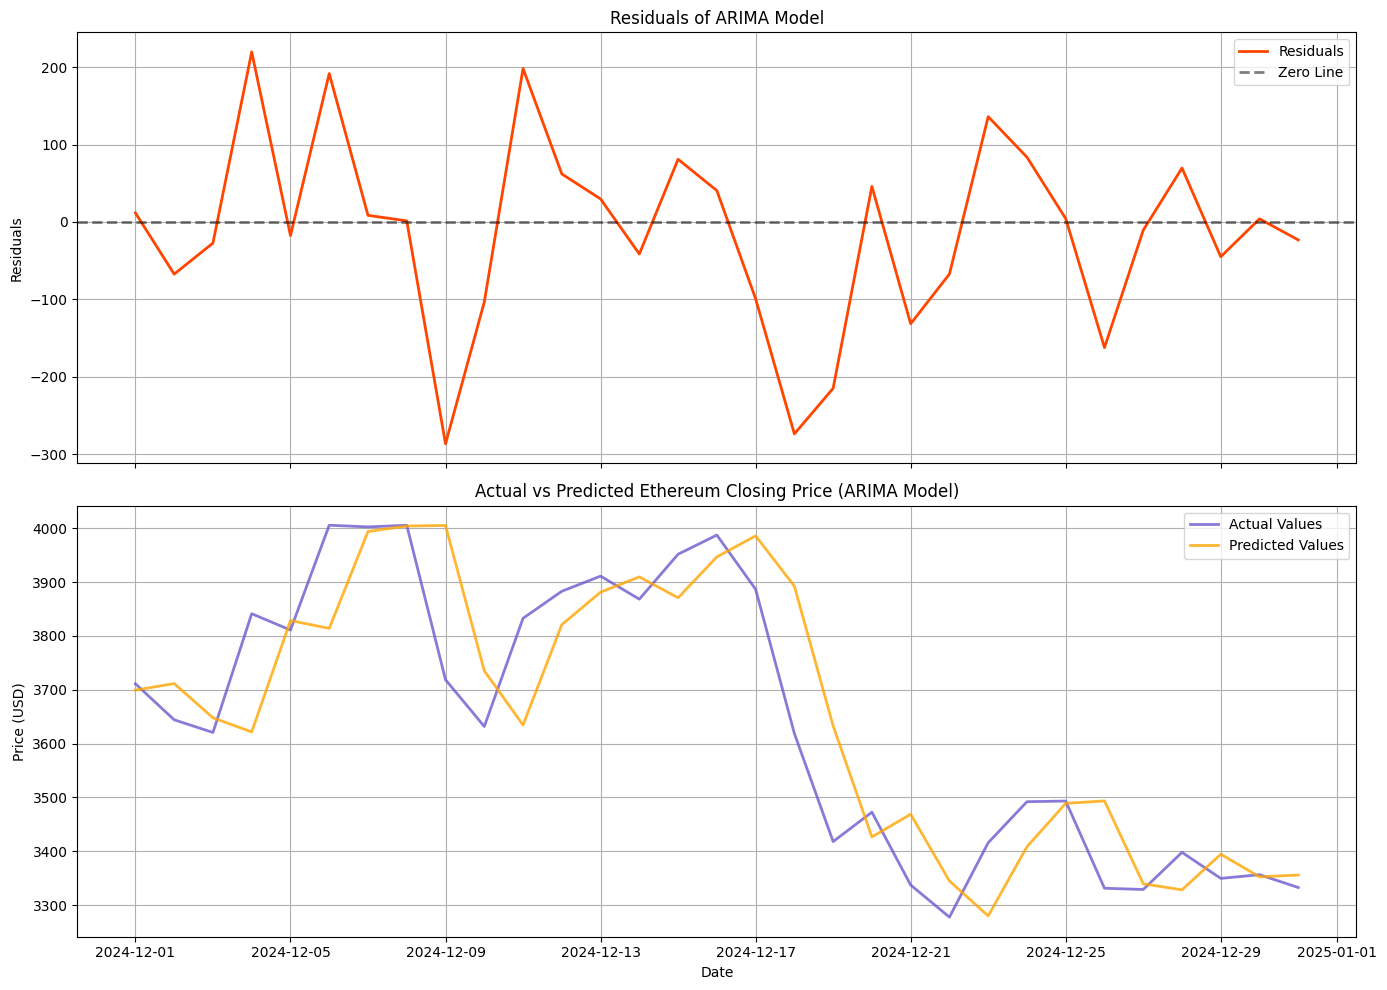

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plot 1: Residuals
sns.lineplot(ax=axes[0], x=test_data.index, y=daily_residuals, color='orangered', label='Residuals', linewidth=2)
axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
axes[0].set_title('Residuals of ARIMA Model')
axes[0].set_ylabel('Residuals')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Actual vs Predicted
axes[1].plot(test_data.index, test_data, color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
axes[1].plot(test_data.index, daily_preds, color='orange', label='Predicted Values', alpha=0.8, linewidth=2)
axes[1].set_title('Actual vs Predicted Ethereum Closing Price (ARIMA Model)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:

mae_daily = mean_absolute_error(test_data.loc[daily_preds.index], daily_preds)
rmse_daily = root_mean_squared_error(test_data.loc[daily_preds.index], daily_preds)
mape_daily = mean_absolute_percentage_error(test_data.loc[daily_preds.index], daily_preds)
r2_daily = r2_score(test_data.loc[daily_preds.index], daily_preds)

print(f"Daily Rolling Forecast Metrics using ARIMA{my_order}:")
print(f"MAE: {mae_daily}")
print(f"RMSE: {rmse_daily}")
print(f"MAPE: {mape_daily}")
print(f"R^2: {r2_daily}")

Daily Rolling Forecast Metrics using ARIMA(1, 1, 1):
MAE: 89.0297770686358
RMSE: 120.75297734001751
MAPE: 0.024510904809618168
R^2: 0.7603131389441595


In [ ]:
p_vals = range(0, 8)
q_vals = range(0, 8)
d = 1

r_arima_weekly = []

for p in p_vals:
    for q in q_vals:
        r_arima_preds = pd.Series(dtype=float)

        try:
            for end_date in test_data.index:
                train_data_roll = data['Close'][:(end_date - timedelta(days=1))]
                
                # Skip if not enough data to fit the model
                if len(train_data_roll) < (p + q + d + 1):
                    continue

                model = ARIMA(train_data_roll, order=(p, d, q))
                model_fit = model.fit()

                # Forecast next day
                pred = model_fit.forecast(steps=7)
                r_arima_preds.loc[end_date] = pred.iloc[0]

            # Align predictions with actual test data
            test_actuals = test_data.loc[r_arima_preds.index]

            mae = mean_absolute_error(test_actuals, r_arima_preds)
            mse = mean_squared_error(test_actuals, r_arima_preds)
            rmse = root_mean_squared_error(test_actuals, r_arima_preds)
            mape = mean_absolute_percentage_error(test_actuals, r_arima_preds)

            r_arima_weekly.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape
            })

            print(f"ARIMA({p},{d},{q}) complete.")

        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")

In [ ]:
df_r_arima_weekly = pd.DataFrame(r_arima_weekly)
df_r_arima_weekly.sort_values(by='RMSE', inplace=True)
df_r_arima_weekly.reset_index(drop=True, inplace=True)
df_r_arima_weekly

In [ ]:
df_r_arima_weekly.to_csv('arima_roll_weekly_results.csv', index=False)

In [ ]:
weekly_best = df_r_arima_weekly.iloc[0]['Order']
print(f"Best ARIMA Weekly Roll order based on RMSE: {weekly_best}")